## EEG Signal Data for Quantum Machine Learning

Dataset Link: https://data.mendeley.com/v1/datasets/px9dpkssy8/draft?a=7140665d-a0f0-40b2-a9fd-a731d21b6222

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC

import random

In [2]:
# ### Note: Store the dataset folder containing all csv files for each subject in the same directory as this ipynb file.

# Prepare the combined csv and save it in the same directory

# # Load the CSV filepaths into a list
# filepaths = glob.glob('dataset/subject*.csv')
# dfs = []
# for filepath in filepaths:
#     df = pd.read_csv(filepath, sep=';')
#     dfs.append(df)

# # Combine the dataframes into a single dataframe
# df = pd.concat(dfs, axis=0, ignore_index=True)

# # Save the preprocessed data to a new CSV file
# df.to_csv('combined_dataset.csv', index=False)

In [3]:
# Read the combined dataset csv

df = pd.read_csv('combined_dataset.csv')
df

,F1,F2,F3,F4
0,410,316,749,520
1,513,297,739,509
2,511,297,738,491
3,492,273,733,558
4,472,285,710,555
...,...,...,...,...
45051,507,546,475,470
45052,512,498,489,500
45053,519,507,462,513
45054,498,528,450,533


In [4]:
# Transpose

df = df.transpose()
df

,0,1,2,3,4,5,6,7,8,9,...,45046,45047,45048,45049,45050,45051,45052,45053,45054,45055
F1,410,513,511,492,472,451,487,498,499,488,...,507,523,537,508,489,507,512,519,498,475
F2,316,297,297,273,285,321,325,330,304,294,...,522,500,532,541,564,546,498,507,528,553
F3,749,739,738,733,710,752,767,758,737,695,...,467,486,466,452,468,475,489,462,450,480
F4,520,509,491,558,555,527,520,494,545,554,...,470,493,495,522,503,470,500,513,533,519


In [5]:
# Dataframe to store extracted features

feature_df = pd.DataFrame(columns=['mean', 'variance', 'skewness', 'kurtosis', 'frequency'])

In [6]:
segment_size = 256

# iterate each row
for rownum in range(df.shape[0]):
    
    # extract segments of segment_size
    for i in range(0, df.shape[1], segment_size):
        
        # extract current segment
        segment = df.iloc[rownum, i:i+segment_size]
        
        # list of features for the segment
        features = []
        
        features.append(segment.mean())
        features.append(segment.var())
        features.append(segment.skew())
        features.append(segment.kurtosis())
        
        # append target frequency (0 corresponds to F1 and so on)
        features.append(int(rownum))
        
        feature_df.loc[len(feature_df)] = features

In [7]:
# Convert frequency column to int

feature_df['frequency'] = feature_df['frequency'].astype('int64')

In [8]:
feature_df

,mean,variance,skewness,kurtosis,frequency
0,502.636719,6469.902803,-0.009519,-0.819542,0
1,651.121094,3211.910769,-0.454366,0.020633,0
2,750.167969,4044.124617,0.976312,0.963696,0
3,651.917969,31766.420695,0.379515,-1.223871,0
4,591.503906,4818.149004,-0.941854,0.162641,0
...,...,...,...,...,...
699,513.761719,1577.750843,0.345208,-0.842939,3
700,518.964844,435.602681,-0.227519,-0.198792,3
701,550.769531,997.385892,0.205590,-0.233249,3
702,477.996094,1113.337240,0.092839,-0.881690,3


In [37]:
# feature_df.to_csv('/Users/sinner/Desktop/eeg_feature_df.csv', index=False)

In [9]:
# Feature Scaling

from sklearn.preprocessing import MinMaxScaler

scaled_df = feature_df.copy()

columns_to_standardize = scaled_df.columns[:-1]

# Create a subset DataFrame with the selected columns
df_to_standardize = scaled_df[columns_to_standardize]

scaler = MinMaxScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_to_standardize))

# Update the original DataFrame with the standardized values
scaled_df[columns_to_standardize] = df_standardized

scaled_df

,mean,variance,skewness,kurtosis,frequency
0,0.522527,0.027656,0.539830,0.078714,0
1,0.695258,0.012871,0.459747,0.143217,0
2,0.810479,0.016648,0.717302,0.215619,0
3,0.696185,0.142455,0.609865,0.047672,0
4,0.625906,0.020161,0.371988,0.154119,0
...,...,...,...,...,...
699,0.535469,0.005455,0.603689,0.076917,3
700,0.541522,0.000272,0.500585,0.126371,3
701,0.578520,0.002821,0.578555,0.123725,3
702,0.493863,0.003348,0.558257,0.073942,3


In [39]:
# scaled_df.to_csv('/Users/sinner/Desktop/eeg_feature_df.csv', index=False)

## Train-test split

In [10]:
from sklearn.model_selection import train_test_split

X = scaled_df.drop(columns=["frequency"]).values
y = scaled_df["frequency"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [11]:
# Define the number of qubits based on the number of features
num_qubits = len(X_train[0])

# Create a quantum circuit with the specified number of qubits
circuit = QuantumCircuit(num_qubits)

## Encoding

In [12]:
for row in X_train:
    for i, amplitude in enumerate(row):
        # Apply the amplitude encoding to each qubit
        circuit.ry(2 * np.arcsin(amplitude), i)

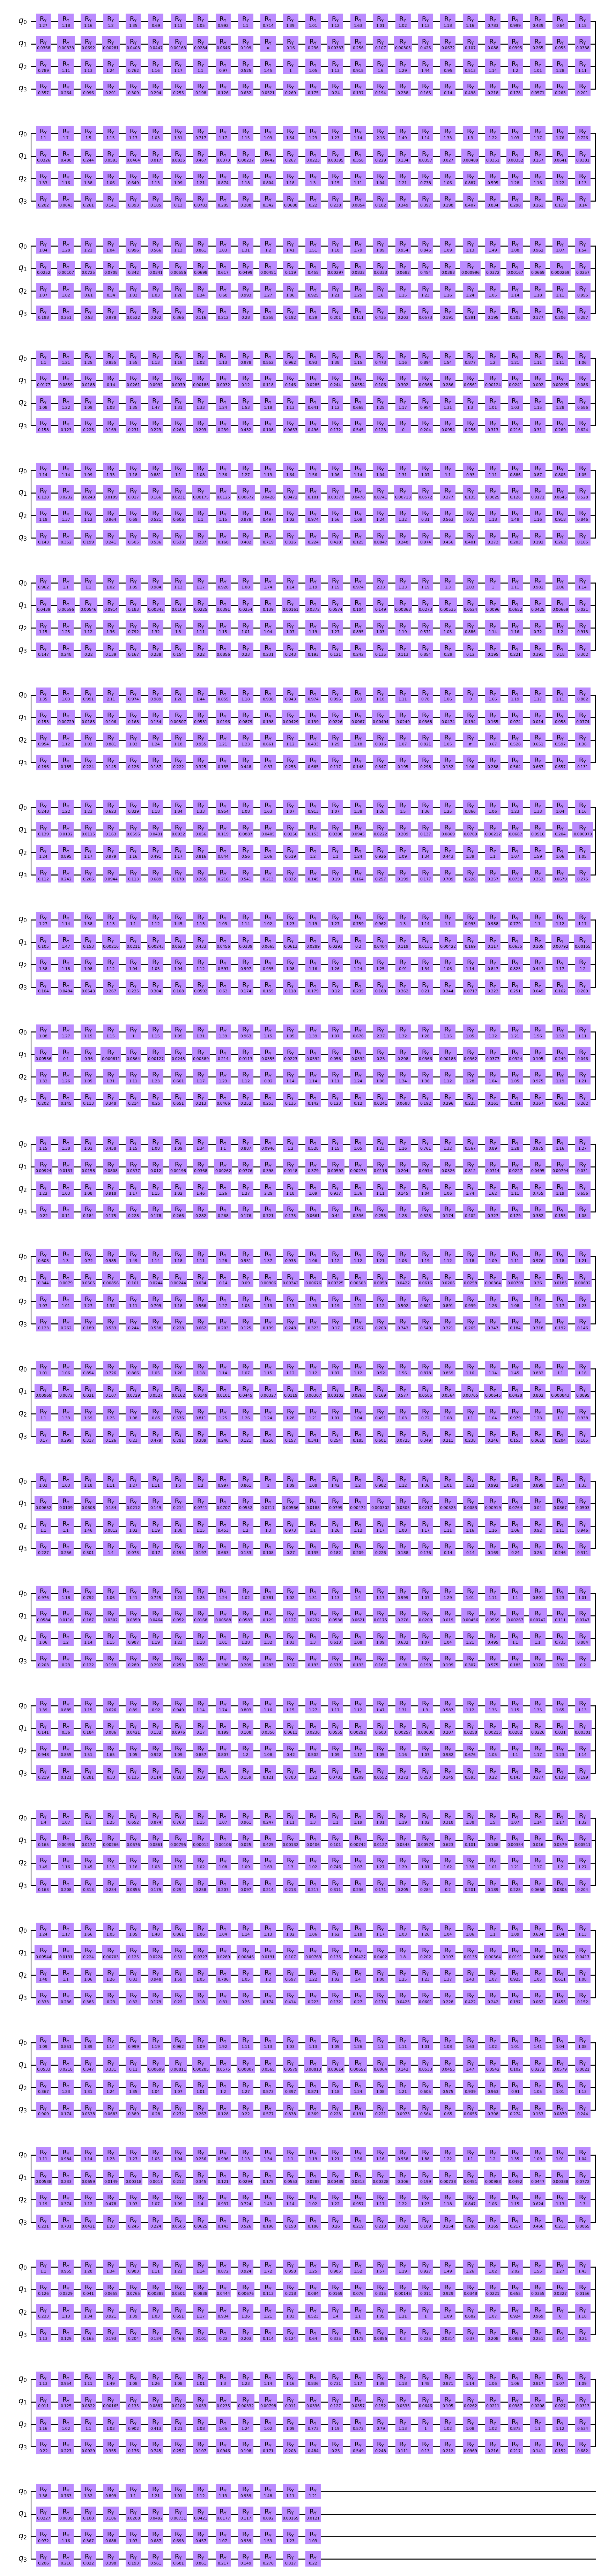

In [13]:
circuit.draw(output="mpl")

## Creating PQC

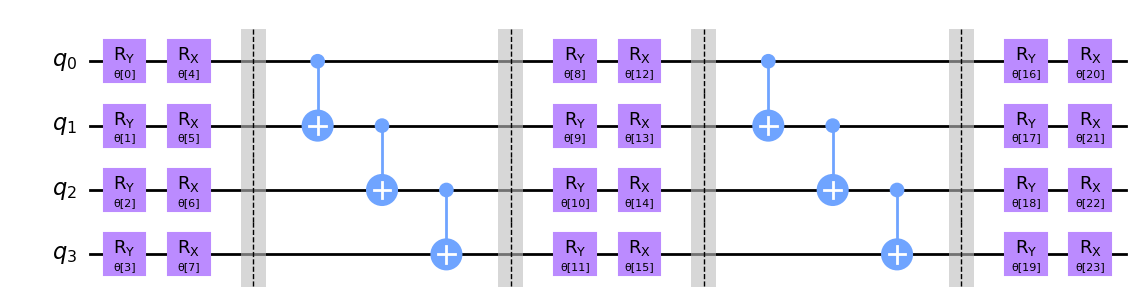

In [14]:
from qiskit.circuit.library import TwoLocal

two = TwoLocal(4, ['ry', 'rx'], 'cx', 'linear', reps=2, insert_barriers=True)
two.decompose().draw(output="mpl")

In [15]:
# Append PQC to encoded qubit circuit

circuit.append(two, range(num_qubits))

In [16]:
params = circuit.parameters
params

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23])])

In [ ]:
QSVM

# Using Qiskit documentation approach
https://learn.qiskit.org/course/machine-learning/variational-classification

In [31]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = X_train, y_train,  X_test, y_test

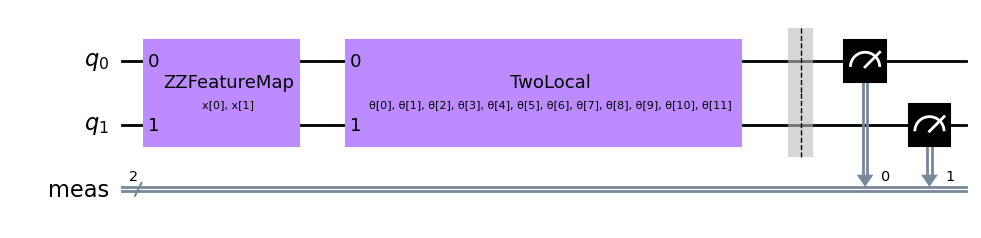

In [32]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)

from qiskit.circuit.library import ZZFeatureMap, TwoLocal

FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.draw(output="mpl")

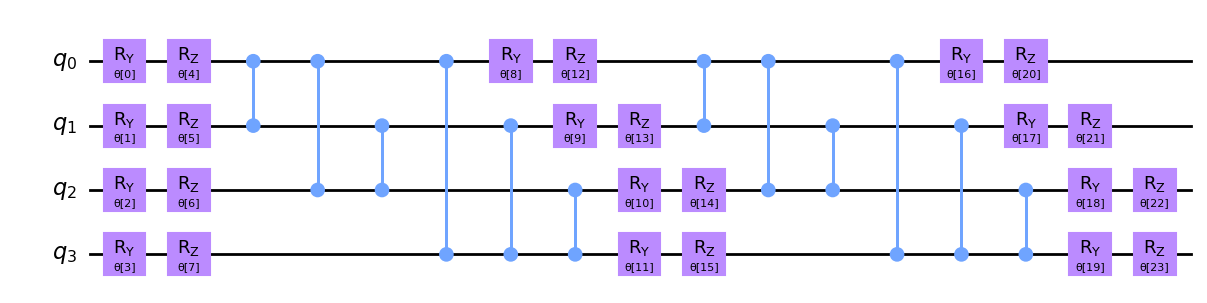

In [35]:
VAR_FORM.decompose().draw(output="mpl")

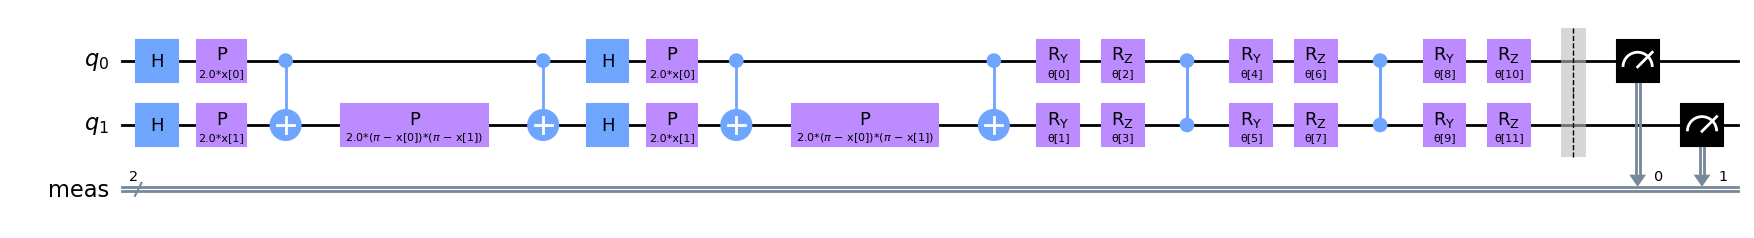

In [33]:
AD_HOC_CIRCUIT.decompose().draw(output="mpl")

In [34]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
# FEATURE_MAP = circuit.copy()
VAR_FORM = TwoLocal(4, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.draw(output="mpl")

CircuitError: "Trying to compose with another QuantumCircuit which has more 'in' edges."

In [25]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)


def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2


def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities


from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)


def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        print(i, labels[i])
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost


class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

In [26]:
# Set up the optimization
from qiskit.algorithms.optimizers import SPSA

log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

# initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])


def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(fun=objective_function, x0=initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

In [27]:
#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(TRAIN_DATA, TRAIN_LABELS)

CircuitError: 'Name conflict on adding parameter: θ[0]'

In [28]:
VAR_FORM.num_parameters

24

# QSVC

In [53]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import aqua_global


seed = 10599
# aqua_globals.random_seed = seed

ModuleNotFoundError: No module named 'qiskit.aqua'

In [61]:
!pip install qiskit-aqua

  Using cached qiskit_aqua-0.9.5-py3-none-any.whl (2.1 MB)
  Using cached h5py-3.2.1.tar.gz (368 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install backend dependencies did not run successfully.
  │ exit code: 1
  ╰─> [590 lines of output]
        Using cached numpy-1.19.3.zip (7.3 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached Cython-0.29.35-py2.py3-none-any.whl (988 kB)
        Using cached pkgconfig-1.5.5-py3-none-any.whl (6.7 kB)
        error: subprocess-exited-with-error
      
        × B